In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from esc_psf.math_module import xp, xcipy, ensure_np_array
from esc_psf import utils, wfe, efc
import esc_psf.esc_fraunhofer as esc

wavelength_c = 650e-9


/home/kianmilani/miniconda3/envs/km311env/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
2025-06-04 10:52:02,487	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


SCoOB interface does not have the required packages to operate.


In [2]:
wfe_data = utils.load_pickle('../data/example_wfe_data_2K.pkl')

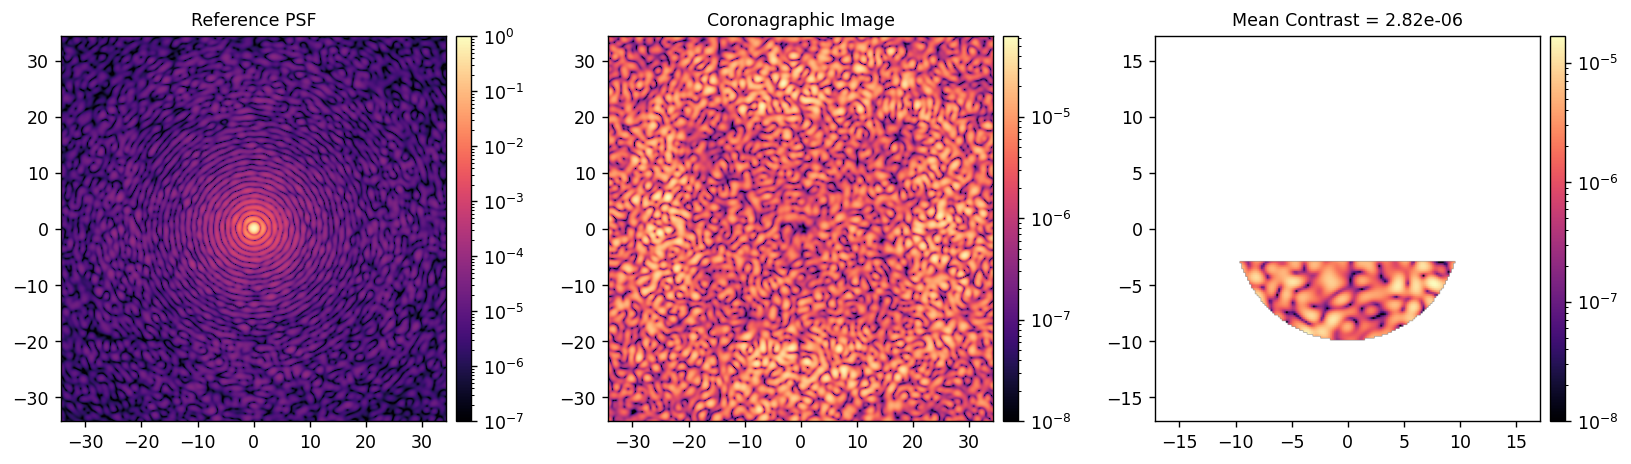

In [16]:
reload(esc)

WFE_SCALE_FACTOR = 1

M = esc.single(
    wavelength_c=wavelength_c, 
    Nact=wfe_data['Nact'],
    total_pupil_diam=wfe_data['total_pupil_diam'],
    dm_beam_diam=wfe_data['dm_beam_diam'],
    act_spacing=wfe_data['act_spacing'], 
    dm_ref=WFE_SCALE_FACTOR*wfe_data['DM_FLAT'],
)
M.ncamsci = 400

M.PREFPM_AMP = wfe_data['PREFPM_AMP']
M.PREFPM_OPD = WFE_SCALE_FACTOR * wfe_data['PREFPM_OPD']
M.POSTFPM_AMP = wfe_data['POSTFPM_AMP']
M.POSTFPM_OPD = wfe_data['POSTFPM_OPD']
M.RLS_AMP = wfe_data['RLS_AMP']
M.RLS_OPD = wfe_data['RLS_OPD']

iwa = 3
owa = 10
control_mask = utils.create_annular_focal_plane_mask(
    M.ncamsci, 
    M.camsci_pxscl_lamD, 
    iwa, 
    owa,  
    edge=iwa,
    rotation=90,
)

M.Imax_ref = 1
M.use_vortex = 0
ref_psf = M.snap_camsci()
M.Imax_ref = xp.max(ref_psf)

M.use_vortex = 1
camsci_im0 = M.snap_camsci()
mean_contrast = xp.mean(camsci_im0[control_mask])

utils.imshow(
    [ref_psf/M.Imax_ref, camsci_im0, camsci_im0*control_mask],
    titles=['Reference PSF', 'Coronagraphic Image', f'Mean Contrast = {mean_contrast:.2e}'], 
    pxscls=3*[M.camsci_pxscl_lamDc],
    norms=[LogNorm(1e-7), LogNorm(1e-8), LogNorm(1e-8)],
    npix=[None, None, 200],
)


In [5]:
M.Nact, M.dm_channels.shape

(48, (10, 48, 48))

In [17]:
reload(efc)

jac = efc.compute_jacobian(
    M, 
    1e-9,
    control_mask, 
    plot=True,
)

In [7]:
calib_data = {
    'jacobian':jac,
}

utils.save_pickle('../data/esc_2K_efc_calibration.pkl', calib_data)

Saved data to:  ../data/esc_2K_efc_calibration.pkl


In [18]:
reload(utils)
cm20 = utils.beta_reg(jac, -2)
cm25 = utils.beta_reg(jac, -2.5)
# cm30 = utils.beta_reg(jac, -3)
# cm35 = utils.beta_reg(jac, -3.5)
# cm40 = utils.beta_reg(jac, -4)
cm45 = utils.beta_reg(jac, -4.5)
cm50 = utils.beta_reg(jac, -5)

In [17]:
jac.shape

(6760, 952)

In [19]:
M.reset_dm()
efc_data = {
    'images':[camsci_im0],
    'contrasts':[mean_contrast],
    'commands':[],
    'efields':[],
    'del_commands':[],
    'pixelscale':M.camsci_pxscl_lamDc,
    'control_mask':control_mask, 
}

In [21]:
control_mask.shape

(500, 500)

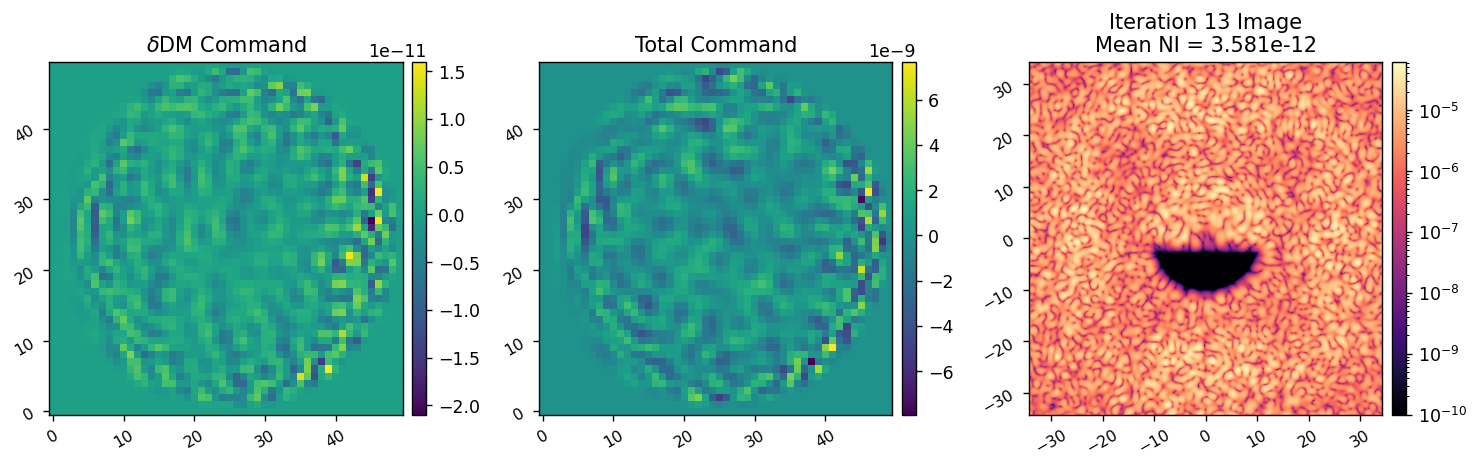

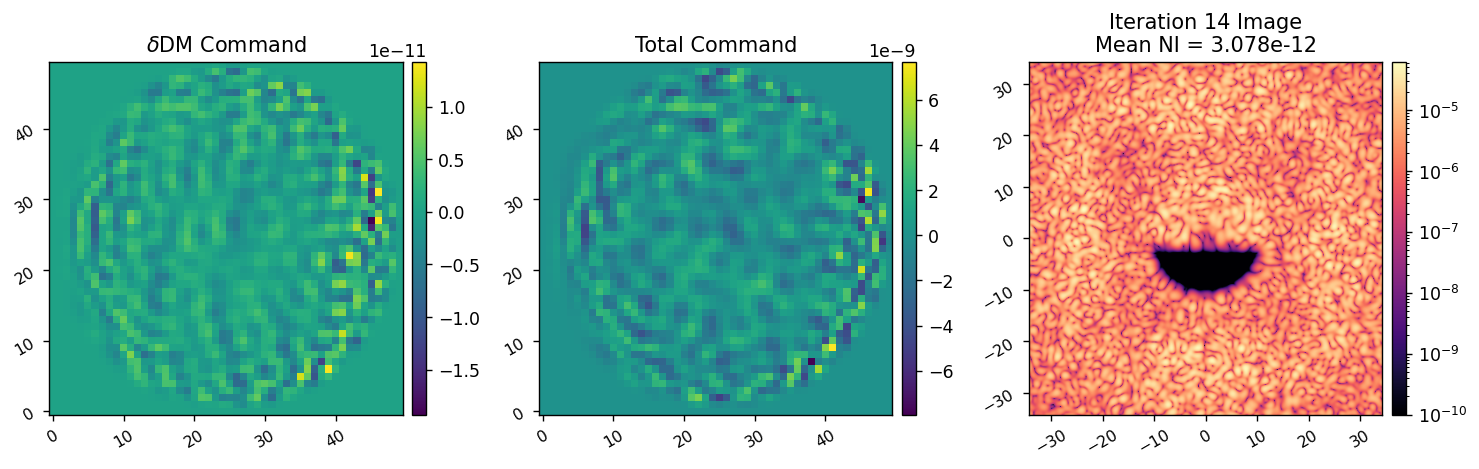

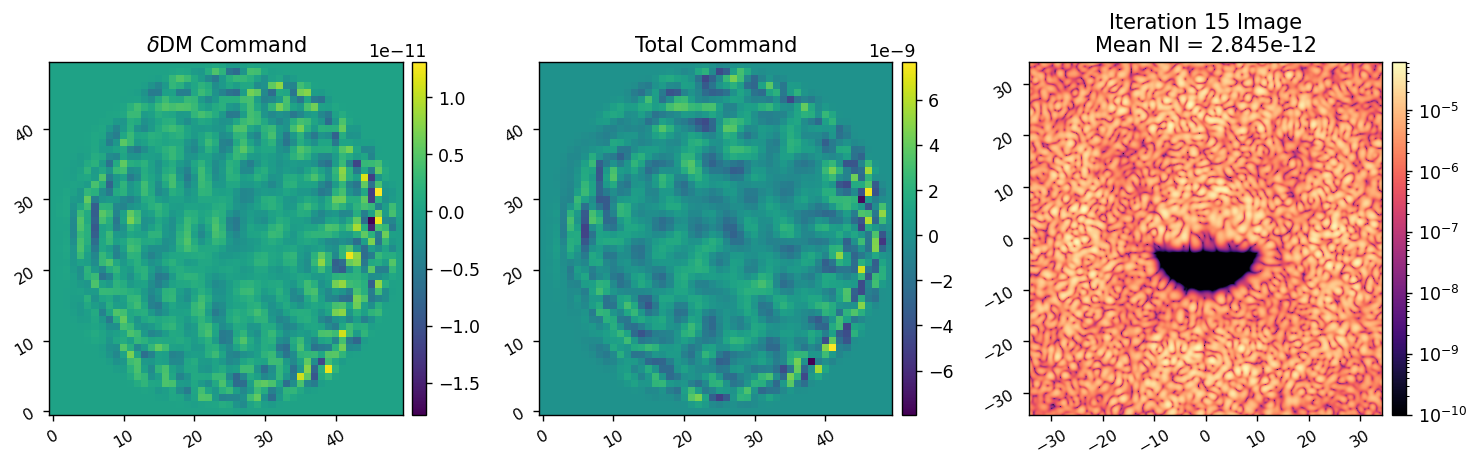

In [24]:
reload(efc)

efc_data = efc.run(
    M,
    # cm20,
    cm25,
    # cm40,
    # cm45,
    # cm50,
    control_mask,
    M.dm_mask,
    efc_data,
    num_iterations=3,
    plot=1,
    vmin=1e-10,
)

In [25]:
wavelength_c = 650e-9

bw1 = 0.02
Nwaves1 = 5
bp1_waves = np.linspace(wavelength_c*(1-bw1/2), wavelength_c*(1+bw1/2), Nwaves1)

bw2 = 0.05
Nwaves2 = 5
bp2_waves = np.linspace(wavelength_c*(1-bw2/2), wavelength_c*(1+bw2/2), Nwaves2)

bw3 = 0.10
Nwaves3 = 10
bp3_waves = np.linspace(wavelength_c*(1-bw3/2), wavelength_c*(1+bw3/2), Nwaves3)


In [26]:
bp1_im = 0.0
for i in range(Nwaves1):
    M.wavelength = bp1_waves[i]
    mono_im = M.snap_camsci()
    bp1_im += mono_im/Nwaves1
bp1_contrast = xp.mean(bp1_im[control_mask])

bp2_im = 0.0
for i in range(Nwaves2):
    M.wavelength = bp2_waves[i]
    mono_im = M.snap_camsci()
    bp2_im += mono_im/Nwaves2
bp2_contrast = xp.mean(bp2_im[control_mask])

bp3_im = 0.0
for i in range(Nwaves3):
    M.wavelength = bp3_waves[i]
    mono_im = M.snap_camsci()
    bp3_im += mono_im/Nwaves3
bp3_contrast = xp.mean(bp3_im[control_mask])

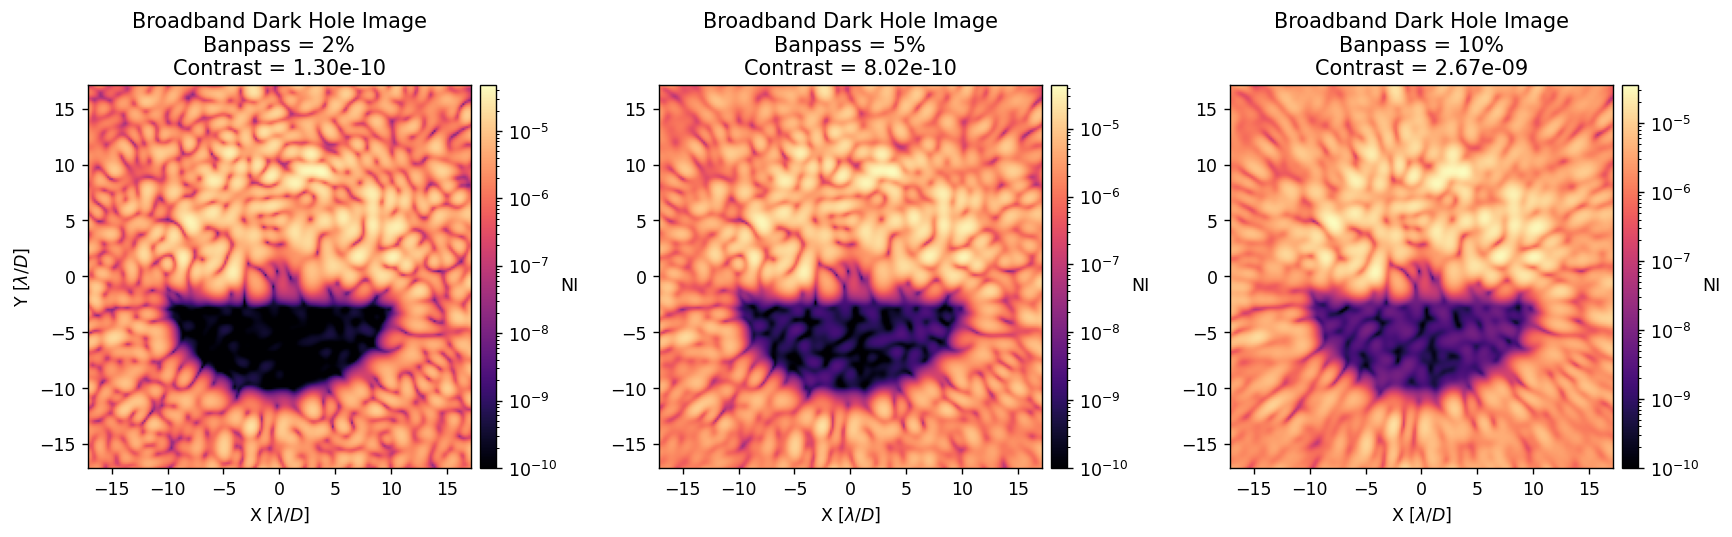

In [27]:
# ticks = np.arange(-30, 30.01, 10)
ticks = np.arange(-15, 15.01, 5)
utils.imshow(
    [bp1_im, bp2_im, bp3_im],
    # [ref_psf/M.Imax_ref, coro_im_0*control_mask, coro_im_flat*control_mask],
    titles=[f'Broadband Dark Hole Image\nBanpass = {100*bw1:.0f}%\nContrast = {bp1_contrast:.2e}',
            f'Broadband Dark Hole Image\nBanpass = {100*bw2:.0f}%\nContrast = {bp2_contrast:.2e}',
            f'Broadband Dark Hole Image\nBanpass = {100*bw3:.0f}%\nContrast = {bp3_contrast:.2e}',],
    title_fzs=[12]*3,
    norms=[LogNorm(vmin=1e-10), LogNorm(vmin=1e-10), LogNorm(vmin=1e-10)],
    pxscls=[M.camsci_pxscl_lamDc]*3,
    npix=3*[200],
    xlabels=['X [$\lambda/D$]']*3,
    ylabels=['Y [$\lambda/D$]', None, None],
    xticks=[ticks]*3,
    yticks=[ticks]*3,
    cmaps=['magma']*3,
    cbar_labels=['NI']*3,
    wspace=0.4,
)